# Importing Libariers & Dataset

In [ ]:
#!pip install timm

In [22]:
import os
import pandas as pd
import timm
import torch
from fastai.vision.all import *
from fastai.vision import models
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings("ignore")
set_seed(42)

print ('modules loaded')

modules loaded


##Dataset Setup

In [ ]:
# Setting up kaggle API
!pip install kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! mkdir ~/.kaggle

In [6]:
!cp /content/drive/MyDrive/Colab_Notebooks/kaggleAPI/kaggle.json ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d mehradaria/leukemia

 97% 107M/110M [00:01<00:00, 91.8MB/s] 
100% 110M/110M [00:01<00:00, 79.4MB/s]


In [ ]:
! unzip leukemia.zip

# Data preprocessing

In [9]:
# Generate data paths with labels
data_dir = '../content/Original'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [10]:
df.head(10)

,filepaths,labels
0,../content/Original/Pro/WBC-Malignant-Pro-323.jpg,Pro
1,../content/Original/Pro/WBC-Malignant-Pro-285.jpg,Pro
2,../content/Original/Pro/WBC-Malignant-Pro-379.jpg,Pro
3,../content/Original/Pro/WBC-Malignant-Pro-387.jpg,Pro
4,../content/Original/Pro/WBC-Malignant-Pro-051.jpg,Pro
5,../content/Original/Pro/WBC-Malignant-Pro-293.jpg,Pro
6,../content/Original/Pro/WBC-Malignant-Pro-765.jpg,Pro
7,../content/Original/Pro/WBC-Malignant-Pro-767.jpg,Pro
8,../content/Original/Pro/WBC-Malignant-Pro-501.jpg,Pro
9,../content/Original/Pro/WBC-Malignant-Pro-085.jpg,Pro


In [11]:
dls = ImageDataLoaders.from_df(df,
                                fn_col=0, # filepaths
                                label_col=1, # labels
                                valid_pct=0.2,
                                folder='',
                                item_tfms=Resize(224))

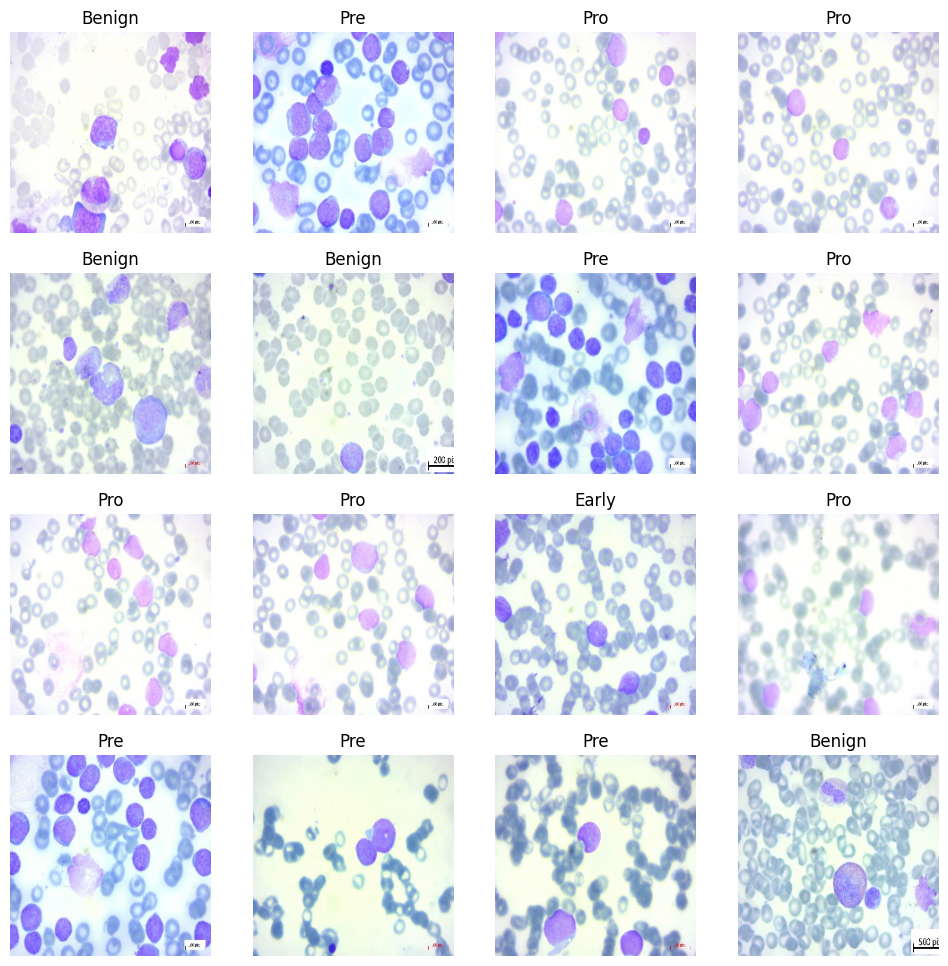

In [12]:
dls.show_batch(max_n=16)

#Model Architecture

In [13]:
learn = vision_learner(dls, 'efficientnet_b3', metrics=[accuracy, error_rate]).to_fp16()
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 112 x 112 
Conv2d                                    1080       False     
Identity                                                       
SiLU                                                           
Conv2d                                    360        False     
Identity                                                       
SiLU                                                           
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                                    440        False     
Sigmoid                            

SuggestedLRs(valley=0.0020892962347716093, slide=0.0002290867705596611)

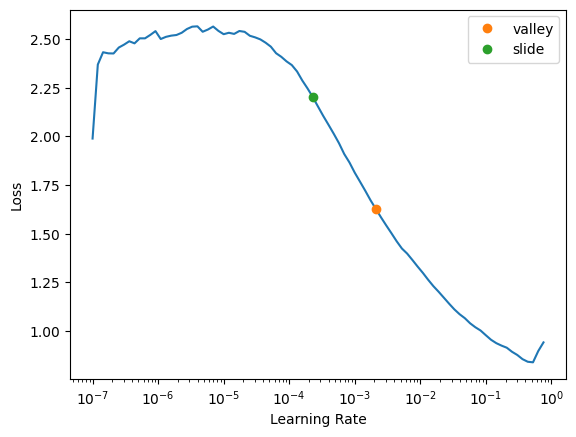

In [14]:
learn.lr_find(suggest_funcs=(valley, slide))

## Model Training

In [15]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.365989,0.250263,0.909370,0.090630,00:14
1,0.595362,0.088338,0.967742,0.032258,00:14
2,0.293158,0.071209,0.976959,0.023041,00:14
3,0.160199,0.063161,0.980031,0.019969,00:15
4,0.088881,0.084804,0.975422,0.024578,00:14
5,0.054674,0.079254,0.975422,0.024578,00:14
6,0.035247,0.070848,0.970814,0.029186,00:14
7,0.020375,0.068957,0.978495,0.021505,00:14
8,0.015589,0.057717,0.978495,0.021505,00:14
9,0.013281,0.053475,0.980031,0.019969,00:14


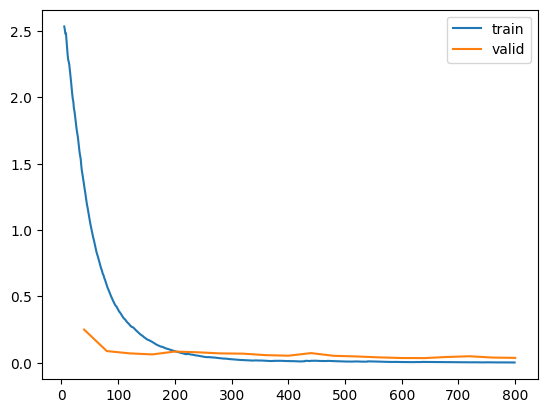

In [16]:
learn.recorder.plot_loss()

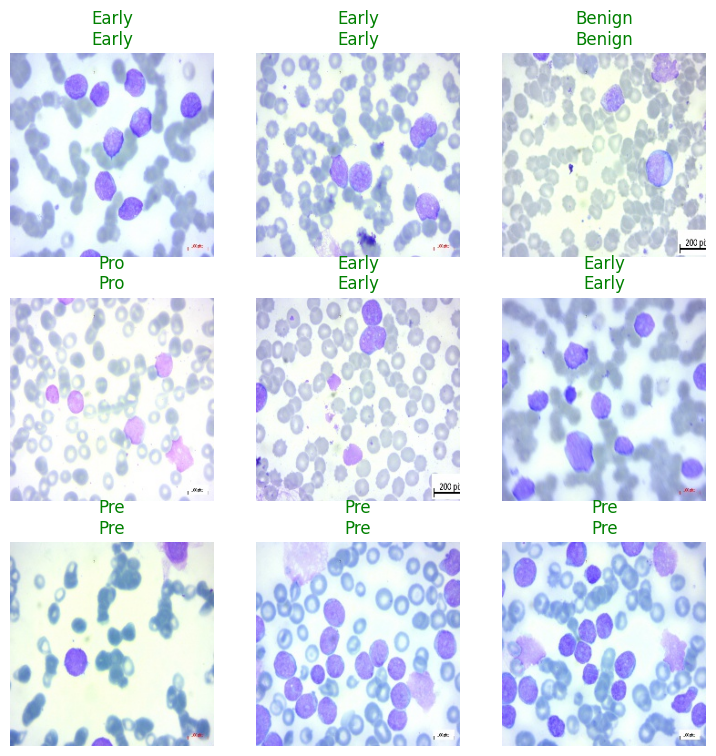

In [17]:
learn.show_results()

In [ ]:
learn.save('/content/drive/MyDrive/Colab_Notebooks/Model')

Path('/content/drive/MyDrive/Colab_Notebooks/Model.pth')

In [18]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model made the worse predictions:
interp = ClassificationInterpretation.from_learner(learn)

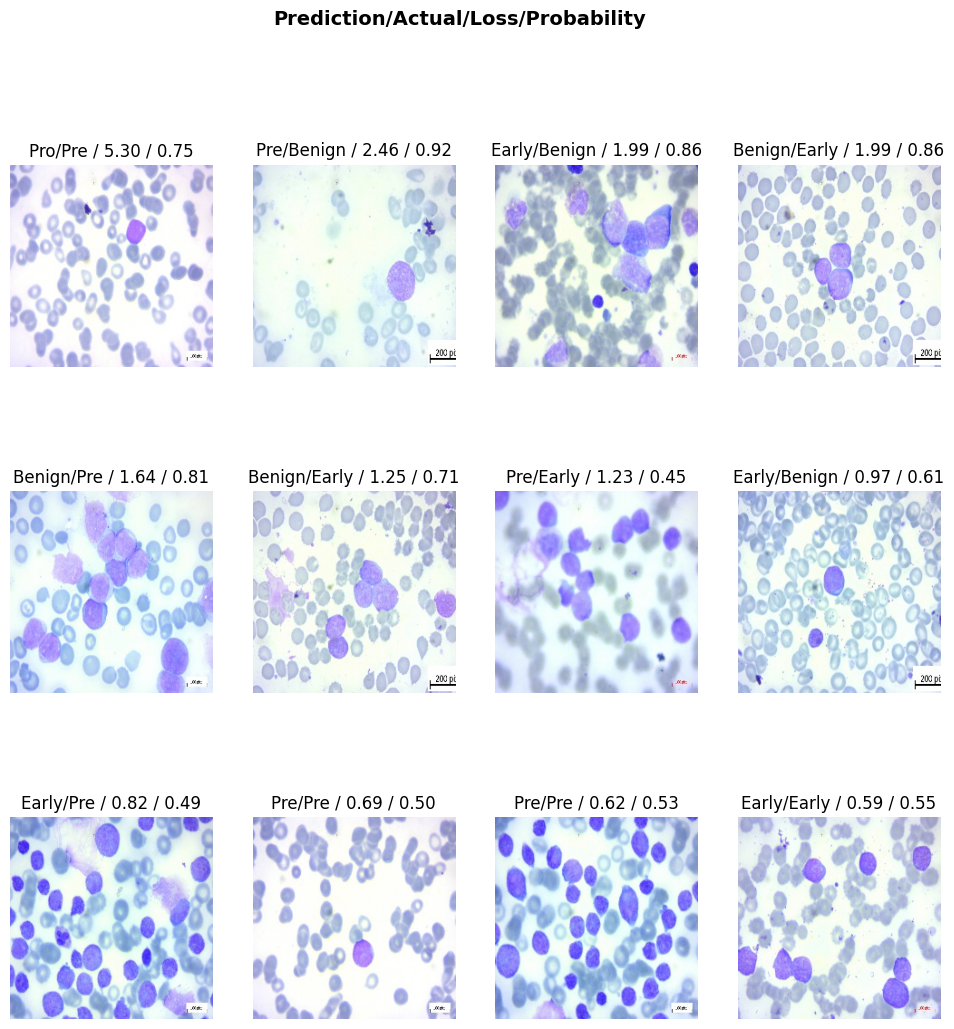

In [19]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(12, figsize=(12,12))

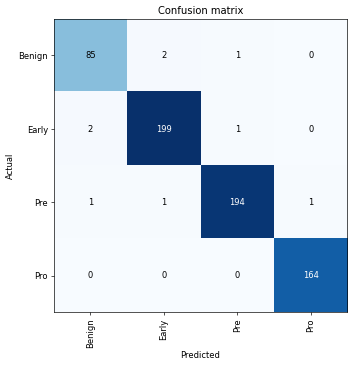

In [20]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [21]:
# learn.freeze()
learn.export('ALL_model.pkl')

In [23]:
torch.save(learn.model.state_dict(),'ALL_model.pth')

In [ ]:
torch.load('ALL_model.pth')


In [25]:
learner = load_learner('ALL_model.pkl')

In [26]:
img = PILImage.create('/content/Original/Benign/WBC-Benign-001.jpg')

In [27]:
pred_class, ti1, ti2 = learner.predict(img)
print("pred_class is: ",pred_class)
predict_string = "Predicted object is: "+pred_class

pred_class is:  Benign
